# **Deep Generative Models: Variational Autoencoders and Generative Adversarial Networks**

# **CK Dataset**
In the following exercices, you will work with images extracted from the CK dataset: http://www.jeffcohn.net/wp-content/uploads/2020/02/Cohn-Kanade_Database.pdf.pdf

It contains gray-scale images of human faces.

The dataset is provided in the folder Data/faces/ in .mat format.
In the following we provide a Dataset class in pytorch to load images from this database.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
torch.Size([256, 1, 64, 64])


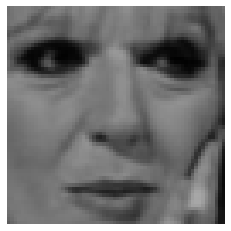

In [12]:
## Create a Custom Dataset for CK database
import scipy.io as sio
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2022/P4/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2022/P4/Results/'

# All the data will be loaded from the provided file in Data/mnist.t
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
from IPython.display import Image as ImageDisp
import scipy.io as sio

#vis_task imports
from torchvision.utils import make_grid
import imageio


#Making native class loader
class FacesDB(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/faces/face_ims_64x64.mat', transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.transform = transform

    # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,0,index]   
        data = Image.fromarray(data,mode='L')
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data

    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

import torchvision.transforms as transforms

tr = transforms.Compose([
        tf.Resize((64,64)),
        transforms.ToTensor(), 
        ])
faces_db = FacesDB(data_path+'/faces/face_ims_64x64.mat',tr)
train_loader = torch.utils.data.DataLoader(dataset=faces_db,
                                           batch_size=256, 
                                           shuffle=True)

#sample for vis_task
ck_sample = torch.utils.data.DataLoader(dataset=faces_db,
                                           batch_size=16, 
                                           shuffle=True)


# Mini-batch images
images = next(iter(train_loader))
print(images.shape)
image = images[0,:,:,:].repeat(3,1,1)
plt.imshow(image.permute(1,2,0).squeeze().numpy())
plt.axis('off')
plt.show()

# Ex. 1

In [ ]:
'''
1. Following the example of the MNIST , train a VAE with the images we have provided for the CK dataset.
2. For every two epochs during training:
  2.1. Visualize a set of reconstructed images and compute the reconstruction error over the whole dataset
  2.2. Generate and show a set of images from random noise z. 
  2.3. Visualize a set of generated images by interpolating over the latent space z.
  2.4 Discuss the different visualizations by analysing their relation with the evolution of the reconstruction loss and the KL regularization term.
'''

'\n1. Following the example of the MNIST , train a VAE with the images we have provided for the CK dataset.\n2. For every two epochs during training:\n  2.1. Visualize a set of reconstructed images and compute the reconstruction error over the whole dataset\n  2.2. Generate and show a set of images from random noise z. \n  2.3. Visualize a set of generated images by interpolating over the latent space z.\n  2.4 Discuss the different visualizations by analysing their relation with the evolution of the reconstruction loss and the KL regularization term.\n'

## Sol. 1

**Defining VAE**

In [ ]:
# Convolution + BatchNormnalization + ReLU block for the encoder
class ConvBNReLU(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(ConvBNReLU, self).__init__()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

    self.pool = None
    if(pooling):
      self.pool = nn.AvgPool2d(2,2)

  def forward(self,x):
    if(self.pool):
      out = self.pool(x)
    else:
      out = x
    out = self.relu(self.bn(self.conv(out)))   
    return out

#  BatchNormnalization + ReLU block + Convolution for the decoder
class BNReLUConv(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(BNReLUConv, self).__init__()
    self.bn = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)

    self.pool = None
    if(pooling):
      self.pool = nn.UpsamplingNearest2d(scale_factor=2)

  def forward(self,x):
    out = self.relu(self.bn(x))
    if(self.pool):
      out = self.pool(out)
    out = self.conv(out)
    return out

# Encoder definition with 3 COnv-BN-ReLU blocks and fully-connected layer
class Encoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Encoder, self).__init__()
    self.layer1 = ConvBNReLU(1,base_channels,pooling=False)
    self.layer2 = ConvBNReLU(base_channels,base_channels*2,pooling=True)
    self.layer3 = ConvBNReLU(base_channels*2,base_channels*4,pooling=True)
    self.fc = nn.Linear(16*16*base_channels*4,out_features)       #8 changed to 16 as we have 64x64 images instead of 32x32
  
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    return self.fc(out.view(x.shape[0],-1))
    
# Decoder definition with a fully-connected layer and 3 BN-ReLU-COnv blocks and 
class Decoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Decoder, self).__init__()
    self.base_channels = base_channels
    self.fc = nn.Linear(out_features,16*16*base_channels*4)     #8 changed to 16 as we have 64x64 images instead of 32x32
    self.layer3 = BNReLUConv(base_channels*4,base_channels*2,pooling=True)
    self.layer2 = BNReLUConv(base_channels*2,base_channels,pooling=True)
    self.layer1 = BNReLUConv(base_channels,1,pooling=False)
  
  def forward(self,x):
    out = self.fc(x)
    out = out.view(x.shape[0],self.base_channels*4,16,16)       #8 changed to 16 as we have 64x64 images instead of 32x32
    out = self.layer3(out)
    out = self.layer2(out)
    out = self.layer1(out)
    return torch.sigmoid(out)

In [ ]:
class VAE(nn.Module):
  def __init__(self, out_features=32,base_channels=16):
    super(VAE, self).__init__()
    # Initialize the encoder and decoder using a dimensionality out_features for the vector z
    self.out_features = out_features
    self.encoder = Encoder(out_features*2,base_channels)
    self.decoder = Decoder(out_features,base_channels)

  # function to obtain the mu and sigma of z for a samples x
  def encode(self,x):
    aux = self.encoder(x)
    # get z mean
    z_mean = aux[:,0:self.out_features]
    # get z variance
    z_log_var = aux[:,self.out_features::]
    return z_mean, z_log_var

  # function to generate a random sample z given mu and sigma
  def sample_z(self,z_mean,z_log_var):
    z_std = z_log_var.mul(0.5).exp()
    samples_unit_normal = torch.randn_like(z_mean)
    samples_z = samples_unit_normal*z_std + z_mean
    return samples_z

  # (1) encode a sample 
  # (2) obtain a random vector z from mu and sigma
  # (3) Reconstruct the image using the decoder
  def forward(self,x):
    z_mean, z_log_var = self.encode(x)
    samples_z = self.sample_z(z_mean,z_log_var)
    x_rec = self.decoder(samples_z)
    return x_rec, z_mean, z_log_var

# Print summary of the mode
print('CK VAE Definition')
vae = VAE(64)
print(vae)

CK VAE Definition
VAE(
  (encoder): Encoder(
    (layer1): ConvBNReLU(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (layer2): ConvBNReLU(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (layer3): ConvBNReLU(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (fc): Linear(in_features=16384, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=64, o

**Train function for VAE**

In [ ]:
def vae_vis_task(model_name, epoch):
  # Load trained VAE
  vae = VAE(64)
  vae.eval() # Evaluation mode for the model
  vae.load_state_dict(torch.load(results_path+'/'+model_name)) # Load model
  vae = vae.to(device)

  ### Generate Images from random noise z ###
  n_samples = 16

  # Random vectors z~N(0,I)
  z = torch.randn((n_samples,vae.out_features)).to(device)

  # Genearte images with the decoder from the random vectors
  x_rec = vae.decoder(z)

  # Show synthetic images
  plt.figure(figsize=(9,9))
  plt.title('Generated Images from random noise z in Epoch '+str(epoch+1))
  image_grid = make_grid(x_rec.cpu(),nrow=4,padding=1)
  plt.imshow(image_grid.permute(1,2,0).detach().numpy())
  plt.show()

  ### Interpolating over generated images ###
  n_iterpolations =50

  # Sample a set of pairs z_init and z_final
  z_init = torch.randn((n_samples,vae.out_features)).to(device)*2
  z_final = torch.randn((n_samples,vae.out_features)).to(device)*2

  # Compute interpolations between z_init and z_final
  # and generate an image for each interpolation.
  interpolation_images = []
  for interp in range(0,n_iterpolations):
    interp_0_1 = float(interp) / (n_iterpolations-1)
    z = z_init*interp_0_1 + z_final*(1-interp_0_1)
    x_rec = vae.decoder(z)
    image_grid = make_grid(x_rec.cpu(),nrow=4,padding=1)
    image_grid = image_grid.permute(1,2,0).detach().numpy()
    # save the generated images in a list
    interpolation_images.append((image_grid*255.0).astype(np.uint8))

  # Concatenate the inversion of the list to generate a "loop" animation
  interpolation_images += interpolation_images[::-1]

  # Generate and visualize a give showing the interpolation results.
  imname = results_path+'/vae_interpolation_ck_E'+str(epoch+1)+'.gif'
  imageio.mimsave(imname, interpolation_images, fps=25)

  with open(imname,'rb') as f:
    display(ImageDisp(data=f.read(), format='png',width=512,height=512))

In [ ]:
## Kullback-Leibler regularization computation
def kl_divergence(z_mean,z_log_var):
  kl_loss = 0.5 * torch.sum(  (torch.exp(z_log_var) + z_mean**2 - 1.0 - z_log_var),axis=1)
  return kl_loss.mean()

# Train function
def train_VAE(vae,  train_loader, optimizer, kl_weight=0.001, num_epochs=10, model_name='vae_ck.ckpt', device='cpu'):
    vae.to(device)
    vae.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.MSELoss() # Use mean-squared error to compare the original and reconstructe images
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        rec_loss_avg = 0
        kl_loss_avg = 0
        nBatches = 0
        for i, images in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)

            # Forward pass (get encoder variables and reconstructed images)
            x_rec, z_mean, z_log_var = vae(images)

            reconstruction_loss = criterion(x_rec, images) # Reconstruction loss (x,x_rec)
            kl_loss = kl_divergence(z_mean, z_log_var) # Compute KL divergecnes KL( N(mu_x,sigma_x) || N(0,I))
            
            # Backward and optimize reconstruction loss and kl regularization
            optimizer.zero_grad()
            loss = reconstruction_loss + kl_loss*kl_weight # we use a weight to balance the importance of the KL loss
            loss.backward()
            optimizer.step()

            rec_loss_avg += reconstruction_loss.cpu().item()
            kl_loss_avg += kl_loss.cpu().item()

            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))
        losses_list.append(rec_loss_avg / nBatches)
        # save trained model
        torch.save(vae.state_dict(), results_path+ '/' + model_name)

        #visualization task every two epochs
        if ((epoch+1)%2 == 0 and epoch != 0):
          vae_vis_task(model_name, epoch)
        
    return losses_list 

**Train VAE**

In [ ]:
# Training a VAE on MNIST: z has 32 dimensions
# We use Adam optimizer which is tipically used in VAEs and GANs

vae = VAE(64)
kl_weight=0.001 

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(vae.parameters(),lr = learning_rate, weight_decay=1e-5)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss_list = train_VAE(vae, train_loader, optimizer, kl_weight=kl_weight,
                      num_epochs=20, model_name='vae_ck.ckpt', device=device)

Output hidden; open in https://colab.research.google.com to view.

# Ex. 2

In [7]:
'''
1. Following the example of the MNIST , train a GAN with the images we have provided for the CK dataset.
2. For every two epochs during training:
  2.1. Generate and show a set of images from random noise z. 
  2.2. Visualize a set of generated images by interpolating over the latent space z.
  2.3 Discuss the different visualizations by analysing their relation between their quality and the evolution of the discriminator and generator losses.
Compare the results with the ones obtained with VAEs
'''

'\n1. Following the example of the MNIST , train a GAN with the images we have provided for the CK dataset.\n2. For every two epochs during training:\n  2.1. Generate and show a set of images from random noise z. \n  2.2. Visualize a set of generated images by interpolating over the latent space z.\n  2.3 Discuss the different visualizations by analysing their relation between their quality and the evolution of the discriminator and generator losses.\nCompare the results with the ones obtained with VAEs\n'

## Sol. 2

GAN definition

In [8]:
# Discriminator similar to VAE encoder
class Discriminator(nn.Module):
  def __init__(self, base_channels=16):
    super(Discriminator, self).__init__()
    # last fully connected layer acts as a a binary classifier
    self.classifier = Encoder(1,base_channels)

  # Forward pass obtaining the discriminator probability
  def forward(self,x):
    out = self.classifier(x)
    # use sigmoid to get the real/fake image probability
    return torch.sigmoid(out)

# Generator is defined as VAE decoder
class Generator(nn.Module):
  def __init__(self,in_features,base_channels=16):
    super(Generator, self).__init__()
    self.base_channels = base_channels
    self.in_features = in_features
    self.decoder = Decoder(in_features,base_channels)

  # Generate an image from vector z
  def forward(self,z):
    return torch.sigmoid(self.decoder(z))

  # Sample a set of images from random vectors z
  def sample(self,n_samples=256,device=device):
    samples_unit_normal = torch.randn((n_samples,self.in_features)).to(device)
    return self.decoder(samples_unit_normal)

GAN Train Function

In [9]:
# GAN Train function. We have a generator and discriminator models and their respective optimizers.
def train_GAN(gen, disc,  train_loader, optimizer_gen, optim_disc,
              num_epochs=10, model_name='gan_faces.ckpt', device=device):
    gen = gen.to(device)
    gen.train() # Set the generator in train mode
    disc = disc.to(device)
    disc.train() # Set the discriminator in train mode

    total_step = len(train_loader)
    losses_list = []

    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        disc_loss_avg = 0
        gen_loss_avg = 0
        nBatches = 0
        update_generator = True

        for i, (real_images) in enumerate(train_loader):
            # Get batch of samples and labels
            real_images = real_images.to(device)
            n_images = real_images.shape[0]

            # Forward pass
            # Generate random images with the generator
            fake_images = gen.sample(n_images,device=device)
            
            # Use the discriminator to obtain the probabilties for real and generate imee
            prob_real = disc(real_images)
            prob_fake = disc(fake_images)
            
            # Generator loss
            gen_loss = -torch.log(prob_fake).mean()
            # Discriminator loss
            disc_loss = -0.5*(torch.log(prob_real) + torch.log(1-prob_fake)).mean()

            
            # We are going to update the discriminator and generator parameters alternatively at each iteration

            if(update_generator):
              # Optimize generator
              # Backward and optimize
              optimizer_gen.zero_grad()
              gen_loss.backward() # Necessary to not erase intermediate variables needed for computing disc_loss gradient
              optimizer_gen.step()
              update_generator = False
            else:           
              # Optimize discriminator
              # Backward and optimize
              optimizer_disc.zero_grad()
              disc_loss.backward()
              optimizer_disc.step()
              update_generator = True
                

            disc_loss_avg += disc_loss.cpu().item()
            gen_loss_avg += gen_loss.cpu().item()

            nBatches+=1
            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        # Save model
        losses_list.append(disc_loss_avg / nBatches)
        torch.save(gan_gen.state_dict(), results_path+ '/' + model_name)

        # visualisation task
        if ((epoch+1)%2 == 0 and epoch != 0):
          gan_vis_task(model_name, epoch)
          
    return losses_list 

Training a GAN

In [10]:
def gan_vis_task(model_name, epoch):
  # Load generator
  gan_gen = Generator(64)
  gan_gen.load_state_dict(torch.load(results_path+'/'+model_name))
  gan_gen.eval() # Put in eval model
  gan_gen = gan_gen.to(device)

  # Generate random images from sampled vectors z and visualize them 
  x_gen = gan_gen.sample(16,device=device)
  image_grid = make_grid(x_gen.cpu(),nrow=4,padding=1)
  plt.figure(figsize=(8,8))
  plt.imshow(image_grid.permute(1,2,0).detach().numpy())
  plt.show()

  n_samples = 16
  n_iterpolations =50

  z_init = torch.randn((n_samples,vae.out_features)).to(device)
  z_final = torch.randn((n_samples,vae.out_features)).to(device)

  interpolation_images = []
  for interp in range(0,n_iterpolations):
    interp_0_1 = float(interp) / (n_iterpolations-1)
    z = z_init*interp_0_1 + z_final*(1-interp_0_1)
    x_rec = gan_gen.decoder(z.to(device))
    image_grid = make_grid(x_rec.cpu(),nrow=4,padding=1)
    image_grid = image_grid.permute(1,2,0).detach().numpy()

    interpolation_images.append((image_grid*255.0).astype(np.uint8))
  interpolation_images += interpolation_images[::-1]

  imname = results_path+'/gan_interpolation_ck_E'+str(epoch+1)+'.gif'
  imageio.mimsave(imname, interpolation_images, fps=25)

  with open(imname,'rb') as f:
    display(ImageDisp(data=f.read(), format='png',width=512,height=512))

In [13]:
# Define Geneartor and Discriminator networks
gan_gen = Generator(64)
gan_disc = Discriminator()

#Initialize indepdent optimizer for both networks
learning_rate = .0005
optimizer_gen = torch.optim.Adam(gan_gen.parameters(),lr = learning_rate, weight_decay=1e-5)
optimizer_disc = torch.optim.Adam(gan_disc.parameters(),lr = learning_rate, weight_decay=1e-5)

# Train the GAN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_list = train_GAN(gan_gen,gan_disc, train_loader, optimizer_gen, optimizer_disc,
                      num_epochs=20, model_name='gan_faces.ckpt', device=device)